In [5]:
%reload_ext autoreload
%autoreload 2

## Import packages

In [6]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
)
from ripple_heterogeneity.replay import (
    replay_run,
    replay_fig,
    replay_participation,
    replay_participation_all_replays,
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
import random
from matplotlib.ticker import AutoMinorLocator
import logging

logging.basicConfig(level=logging.INFO)


## default plotting

In [7]:
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## Load replay data

In [8]:
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_v7"
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'

df = replay_run.load_results(save_path, pre_task_post=True)


## run replay participation analysis

replay_participation_all_replays

In [9]:
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_v7"
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'

# save_path_cur_analysis = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_v7_sessions_task_post"
# )
save_path_cur_analysis = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_all_sessions_task_post"
)
batch_analysis.run(
    df,
    save_path_cur_analysis,
    replay_participation_all_replays.run,
    parallel=True,
    verbose=True,
    overwrite=False,
    skip_if_error=False,
    replay_df=df,
    replay_save_path=save_path,
    alpha=0.05,
    min_spk_count=0,
)

# read back in
# save_path_cur_analysis = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_v7_sessions_task_post"
# )
sessions = glob.glob(save_path_cur_analysis + os.sep + "*.pkl")
par_df = pd.DataFrame()
for session in sessions:
    with open(session, "rb") as f:
        results = pickle.load(f)
    par_df = pd.concat([par_df, results])


100%|██████████| 63/63 [00:03<00:00, 18.95it/s] 


## add deep sup class from deep sup distance

In [10]:
par_df = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(par_df)
for basepath in par_df.basepath.unique():
    par_df.loc[par_df.basepath == basepath, "animal_id"] = loading.get_animal_id(basepath)


## plot replay partic prob. between layers

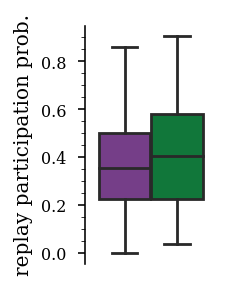

In [11]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

# keep_idx = (par_df.n_replays > 30) & (~par_df.basepath.str.contains('GirardeauG'))
keep_idx = (par_df.n_replays > 30)

sns.boxplot(
    x="epoch",
    y="replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
# sns.stripplot(
#     x="epoch",
#     y="replay_par",
#     hue="deepSuperficial",
#     hue_order=group_colors.keys(),
#     data=par_df[keep_idx],
#     dodge=True,
#     color="k",
#     size=3,
#     alpha=0.5,
# )
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
ax.set_ylabel("replay participation prob.")

plt.savefig(
    os.path.join(fig_save_path, "replay_participation_05_11_22.svg"),
    dpi=300,
    bbox_inches="tight",
)
# par_df[keep_idx].basepath.unique()

## See replay firing rate gain

In [184]:
par_df["replay_fr_gain"] = par_df["replay_fr"] / par_df["non_replay_fr"]

Text(0.5, 0, '')

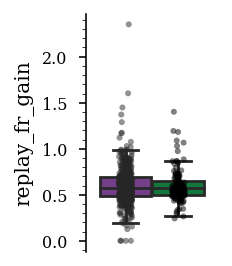

In [185]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

# keep_idx = (par_df.n_replays > 30) & (~par_df.basepath.str.contains('GirardeauG'))
keep_idx = (par_df.n_replays > 30)

sns.boxplot(
    x="epoch",
    y="replay_fr_gain",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="replay_fr_gain",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
# ax.set_ylabel("non_replay_fr firing rate (Hz)")

# ax.set_yscale("log")
# plt.savefig(
#     os.path.join(fig_save_path, "replay_fr_05_11_22.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )
# par_df[keep_idx].basepath.unique()

## Test python mixed lm model

In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder

temp_df = par_df[(par_df.deepSuperficial != "middle") & (par_df.n_replays > 30)]

lbl=LabelEncoder()
temp_df['basepath_encoded'] = lbl.fit_transform(temp_df[['basepath']])
temp_df['deepSuperficial_encoded'] = lbl.fit_transform(temp_df[['deepSuperficial']])

temp_df["Intercept"] = 1
exog = temp_df[["Intercept", "deepSuperficial_encoded"]]
md = sm.MixedLM(temp_df["replay_par"], exog, groups=temp_df["basepath_encoded"], exog_re=exog["Intercept"])
mdf = md.fit()
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    replay_par
No. Observations:    601        Method:                REML      
No. Groups:          24         Scale:                 0.0388    
Min. group size:     4          Log-Likelihood:        101.4706  
Max. group size:     55         Converged:             Yes       
Mean group size:     25.0                                        
-----------------------------------------------------------------
                        Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.395    0.019 21.193 0.000  0.359  0.432
deepSuperficial_encoded 0.040    0.022  1.818 0.069 -0.003  0.082
Intercept Var           0.006    0.012                           



C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


## Forward / Reverse 

make wide to long df

In [63]:
par_df_long = pd.melt(
    par_df[keep_idx],
    id_vars=["basepath", "UID", "deepSuperficial"],
    value_vars=["forward_replay_par", "reverse_replay_par"],
    var_name="replay_type",
    value_name="replay_participation",
)
par_df_long


,basepath,UID,deepSuperficial,replay_type,replay_participation
0,Z:\Data\AYAold\AYA6\day17,25,Superficial,forward_replay_par,0.187500
1,Z:\Data\AYAold\AYA6\day17,27,Deep,forward_replay_par,0.312500
2,Z:\Data\AYAold\AYA6\day17,29,Superficial,forward_replay_par,0.062500
3,Z:\Data\AYAold\AYA6\day17,30,Superficial,forward_replay_par,0.125000
4,Z:\Data\AYAold\AYA6\day17,31,Superficial,forward_replay_par,0.000000
...,...,...,...,...,...
1765,Z:\Data\Kenji\ec014.459_480,75,Deep,reverse_replay_par,0.620690
1766,Z:\Data\Kenji\ec014.459_480,76,Deep,reverse_replay_par,0.413793
1767,Z:\Data\Kenji\ec014.459_480,77,Deep,reverse_replay_par,0.241379
1768,Z:\Data\Kenji\ec014.459_480,82,Deep,reverse_replay_par,0.500000


### look at forward and reverse

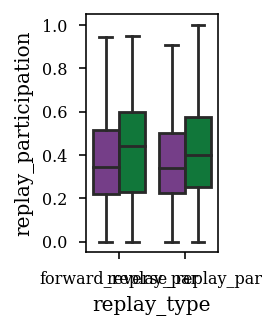

In [112]:
# fig = plt.figure(
#     figsize=functions.set_size("thesis", fraction=0.5, subplots=(3, 1)), edgecolor=None
# )
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    x="replay_type",
    y="replay_participation",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df_long,
    showfliers=False,
)
ax = plt.gca()
ax.get_legend().remove()


In [105]:
par_df_long['replay_type_ca1_layer'] = par_df_long['replay_type'] + '_' + par_df_long['deepSuperficial']
par_df_long['replay_type_ca1_layer'].unique()

array(['forward_replay_par_Superficial', 'forward_replay_par_Deep',
       'forward_replay_par_middle', 'reverse_replay_par_Superficial',
       'reverse_replay_par_Deep', 'reverse_replay_par_middle'],
      dtype=object)

### paired plot of forward and reverse

<AxesSubplot:xlabel='replay_type', ylabel='replay_participation'>

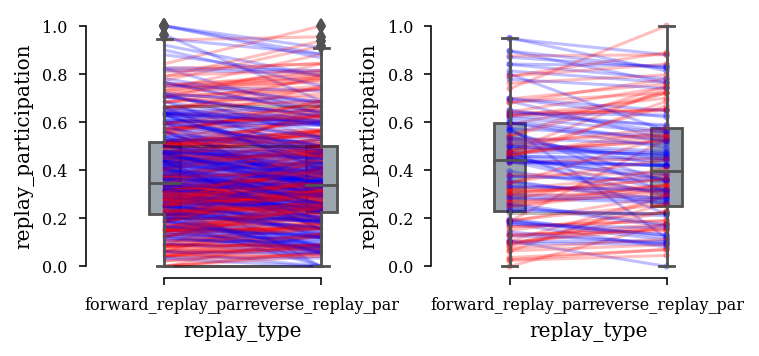

In [87]:
import pingouin as pg

fig, axs = plt.subplots(1, 2, figsize=functions.set_size(
    'thesis', fraction=1, subplots=(2, 3)), edgecolor='k')
fig.subplots_adjust(hspace=.2, wspace=.1)
axs = axs.ravel()

ax = plt.gca()
par_df_long["basepath_UID"] = par_df_long.basepath + "_" + par_df_long.UID.astype(str)

pg.plot_paired(
    data=par_df_long[par_df_long.deepSuperficial == "Deep"],
    dv="replay_participation",
    within="replay_type",
    subject="basepath_UID",
    ax=axs[0],
    pointplot_kwargs={"alpha": 0.25, "s": .5},colors=['r','k','b'],
)
pg.plot_paired(
    data=par_df_long[par_df_long.deepSuperficial == "Superficial"],
    dv="replay_participation",
    within="replay_type",
    subject="basepath_UID",
    ax=axs[1],
    pointplot_kwargs={"alpha": 0.25},colors=['r','k','b']
)

In [114]:
# par_df["forward_reverse_ratio"] = (
#     par_df.forward_replay_par - par_df.reverse_replay_par
# ) / (par_df.forward_replay_par + par_df.reverse_replay_par)

# par_df["forward_reverse_ratio"] = (
#     par_df.forward_replay_par - par_df.reverse_replay_par
# )

par_df["forward_reverse_ratio"] = (
    par_df.forward_replay_par / par_df.reverse_replay_par
)

In [97]:
(par_df[par_df.deepSuperficial == "Deep"].forward_reverse_ratio > 1).sum()
(par_df[par_df.deepSuperficial == "Deep"].forward_reverse_ratio < 1).sum()

(par_df[par_df.deepSuperficial == "Superficial"].forward_reverse_ratio > 1).sum(),(par_df[par_df.deepSuperficial == "Superficial"].forward_reverse_ratio < 1).sum()

(123, 117)

### Forward / Reverse for main fig

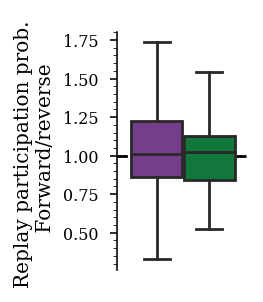

In [118]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    x="epoch",
    y="forward_reverse_ratio",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
    # boxprops=dict(alpha=.7)

# sns.stripplot(
#     x="epoch",
#     y="forward_reverse_ratio",
#     hue="deepSuperficial",
#     hue_order=group_colors.keys(),
#     data=par_df[keep_idx],
#     dodge=True,
#     color="k",
#     size=3,
#     alpha=0.5,
# )
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_xaxis().set_ticks([])
ax.spines["bottom"].set_visible(False)
ax.get_legend().remove()
ax.set_xlabel("")
ax.axhline(1, linestyle="--", color="k",zorder=-1000)

ax.set_ylabel("Replay participation prob. \n Forward/reverse")

plt.savefig(
    os.path.join(fig_save_path, "replay_participation_replay_type.svg"),
    dpi=300,
    bbox_inches="tight",
)

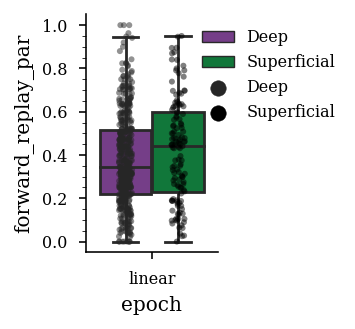

In [15]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

sns.boxplot(
    x="epoch",
    y="forward_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="forward_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
# plt.yscale("log")

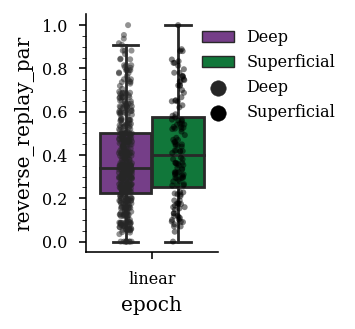

In [16]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

sns.boxplot(
    x="epoch",
    y="reverse_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    y="reverse_replay_par",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    data=par_df[keep_idx],
    dodge=True,
    color="k",
    size=3,
    alpha=0.5,
)
plt.legend(
    bbox_to_anchor=(2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
sns.despine()
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
# plt.yscale("log")

## save csv

In [17]:
# par_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_v7_task_post.csv")
# replay_participation_for_all_sessions_task_post
par_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\replay_participation_for_all_sessions_task_post.csv")


## visualize with dabest

In [155]:
temp_df_1 = pd.DataFrame()
keep_idx = (par_df.n_replays > 30)

temp_df_1['forward'] = par_df[keep_idx & (par_df.deepSuperficial=="Deep")].forward_replay_par.values
temp_df_1['reverse'] = par_df[keep_idx & (par_df.deepSuperficial=="Deep")].reverse_replay_par.values
temp_df_1['ID'] = par_df[keep_idx & (par_df.deepSuperficial=="Deep")].basepath_UID.values
temp_df_1['deepSuperficial'] = ["Deep"] * len(temp_df_1)

temp_df_2 = pd.DataFrame()
temp_df_2['forward'] = par_df[keep_idx & (par_df.deepSuperficial=="Superficial")].forward_replay_par.values
temp_df_2['reverse'] = par_df[keep_idx & (par_df.deepSuperficial=="Superficial")].reverse_replay_par.values
temp_df_2['ID'] = par_df[keep_idx & (par_df.deepSuperficial=="Superficial")].basepath_UID.values

temp_df_2['deepSuperficial'] = ["Superficial"] * len(temp_df_2)
temp_df = pd.concat([temp_df_1, temp_df_2],ignore_index=True)
temp_df

,forward,reverse,ID,deepSuperficial
0,0.312500,0.352941,Z:\Data\AYAold\AYA6\day17_27,Deep
1,0.125000,0.235294,Z:\Data\AYAold\AYA6\day17_33,Deep
2,0.187500,0.411765,Z:\Data\AYAold\AYA6\day17_36,Deep
3,0.437500,0.470588,Z:\Data\AYAold\AYA6\day17_37,Deep
4,0.375000,0.294118,Z:\Data\AYAold\AYA6\day17_40,Deep
...,...,...,...,...
596,0.777778,0.740741,Z:\Data\HMC1\day8_275,Superficial
597,0.619048,0.555556,Z:\Data\HMC1\day8_279,Superficial
598,0.450000,0.687500,Z:\Data\Kenji\ec013.634_653_61,Superficial
599,0.950000,0.812500,Z:\Data\Kenji\ec013.634_653_66,Superficial


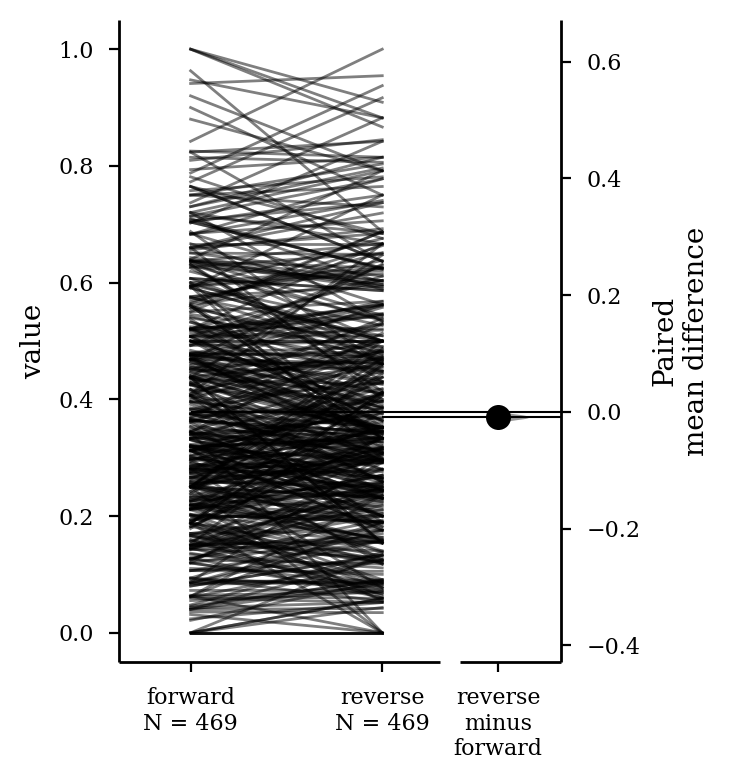

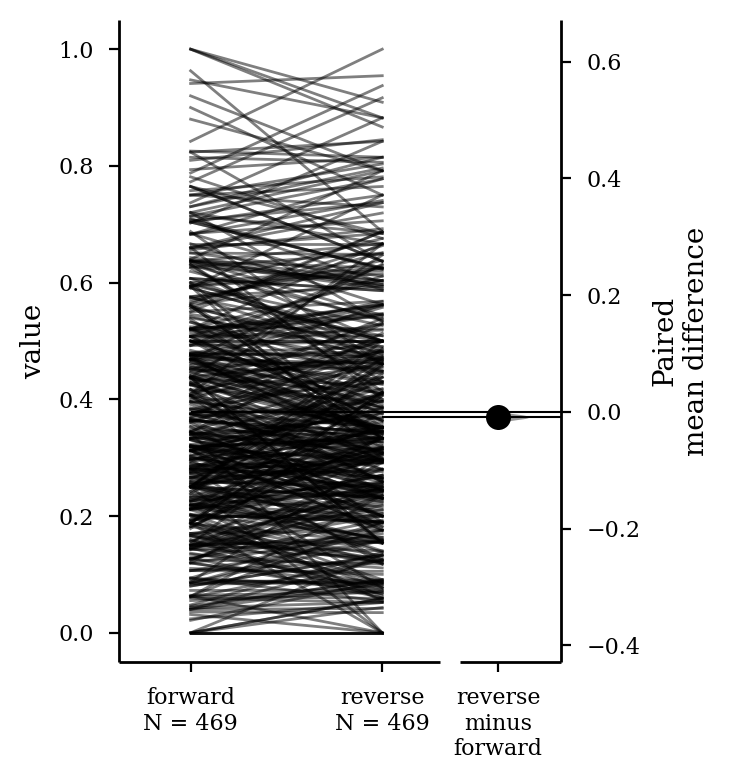

In [174]:
import dabest
multi_2group_paired = dabest.load(temp_df[temp_df['deepSuperficial'] == "Deep"], idx=("forward", "reverse"),
                                paired=True, id_col=("ID")
                                )
multi_2group_paired.mean_diff.plot()


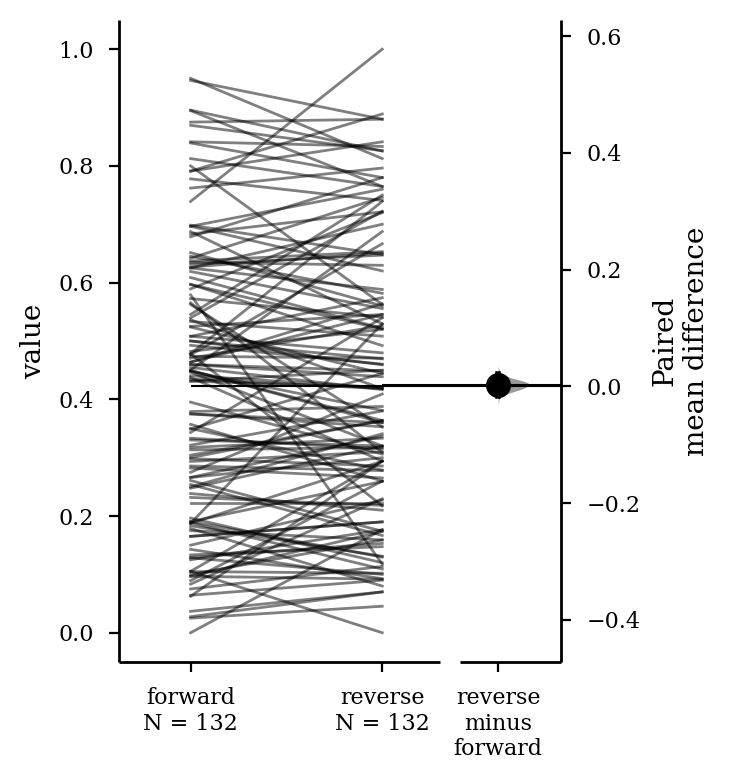

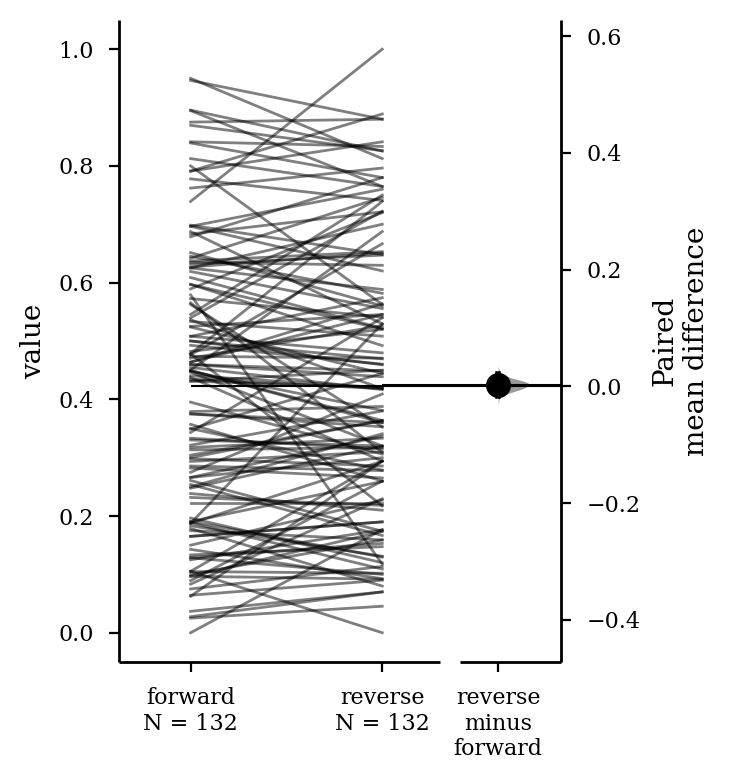

In [180]:
multi_2group_paired = dabest.load(temp_df[temp_df['deepSuperficial'] == "Superficial"], idx=("forward", "reverse"),
                                paired=True, id_col=("ID")
                                )
multi_2group_paired.mean_diff.plot()